## Simple Dask Client Demo

### Simple Code

In [2]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [3]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 2.68 ms, sys: 100 µs, total: 2.78 ms
Wall time: 3 s


### Parallelize with the <i><small>dask.delayed</small></i> decorator

In [4]:
from dask import delayed
from dask.distributed import Client

client = Client("172.24.201.182:8786")

In [5]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 0 ns, sys: 3.1 ms, total: 3.1 ms
Wall time: 1.67 ms


### Compute the real value

In [6]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 68.2 ms, sys: 6.06 ms, total: 74.3 ms
Wall time: 2.08 s


5

### Type Delayed

In [7]:
z

Delayed('add-29999a8a-a6c2-4ff9-ba6a-d8664e3d8e1c')

### View the exec plan

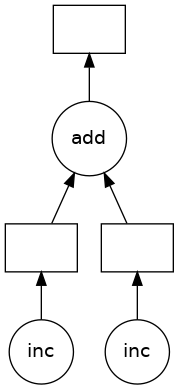

In [8]:
# Look at the task graph for `z`
z.visualize()

### Parallelize a for loop

In [9]:
# Data 
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [10]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)

total = sum(results)

CPU times: user 6.45 ms, sys: 1.15 ms, total: 7.6 ms
Wall time: 8.01 s


In [11]:
# Get Total value
total

44

In [12]:
%%time
# Parallel code
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)

total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

Before computing: Delayed('sum-33d24885-31ff-4237-97dc-a510a2355840')
After computing : 44
CPU times: user 15.1 ms, sys: 0 ns, total: 15.1 ms
Wall time: 1.04 s


In [13]:
# Delayed 
total

Delayed('sum-33d24885-31ff-4237-97dc-a510a2355840')

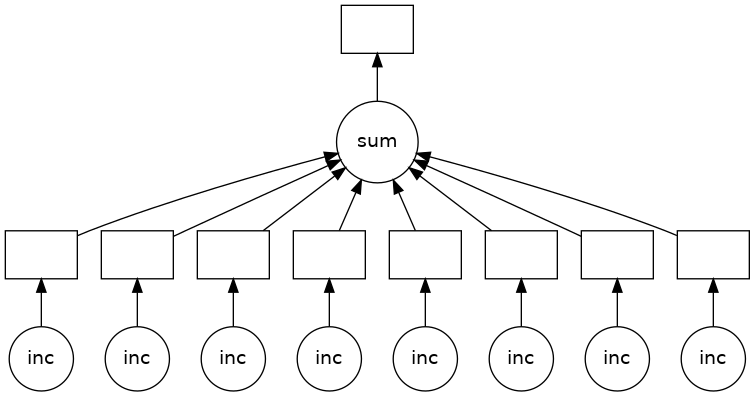

In [14]:
# Look at the task graph for `total`
total.visualize()

### Parallelize a for loop with control flow

In [15]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [16]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)

total = sum(results)
print(total)

90
CPU times: user 9.96 ms, sys: 0 ns, total: 9.96 ms
Wall time: 10 s


In [17]:
%%time
results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)

total = delayed(sum)(results)

CPU times: user 4.81 ms, sys: 0 ns, total: 4.81 ms
Wall time: 2.76 ms


In [18]:
%time total.compute()

CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 1.02 s


90

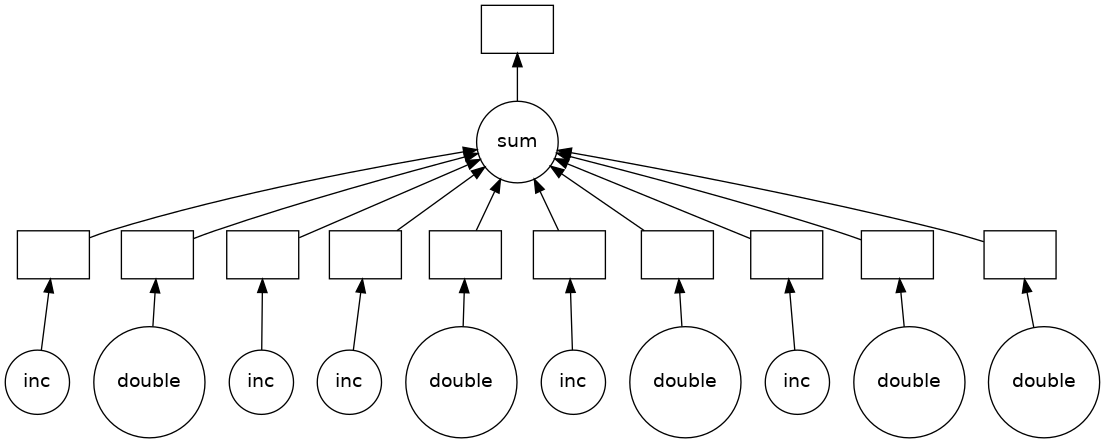

In [19]:
total.visualize()

### Demo with Pandas 

In [69]:
import os
# You must change this with your own path
path = '/mnt/d/work/vhio/code/dask-demo/data/'
sorted(os.listdir(path))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv',
 '2000.csv',
 '2001.csv',
 '2002.csv',
 '2003.csv',
 '2004.csv',
 '2005.csv',
 '2006.csv',
 '2007.csv',
 '2008.csv']

In [71]:
import pandas as pd
df = pd.read_csv(os.path.join(path, '1990.csv'))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1990,1,3,3,1707.0,1630,1755.0,1723,US,29,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,1990,1,4,4,1706.0,1630,1807.0,1723,US,29,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,1990,1,5,5,1629.0,1630,1715.0,1723,US,29,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,1990,1,6,6,1633.0,1630,1718.0,1723,US,29,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,1990,1,8,1,1630.0,1630,1726.0,1723,US,29,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [72]:
# Schema
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
CancellationCode     float64
Diverted               int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtype: object

In [73]:
df.Origin.unique()

array(['CMH', 'IND', 'LAX', 'PHL', 'PIT', 'SFO', 'BDL', 'MSY', 'EWR',
       'BWI', 'MCI', 'SAN', 'MDT', 'MCO', 'LGA', 'PSP', 'TPA', 'IAD',
       'DAY', 'CLE', 'ABE', 'ISP', 'BUR', 'DCA', 'PHX', 'FLL', 'PVD',
       'ABQ', 'TUS', 'TYS', 'LAS', 'MIA', 'SYR', 'DTW', 'BOS', 'EVV',
       'BTV', 'PBI', 'OAK', 'ERI', 'ONT', 'PDX', 'ROC', 'CLT', 'SEA',
       'SNA', 'GRR', 'DFW', 'AVP', 'IAH', 'ORD', 'JFK', 'RIC', 'RNO',
       'BUF', 'TOL', 'SAV', 'SMF', 'RDU', 'CVG', 'STL', 'PHF', 'MKE',
       'ALB', 'BNA', 'MEM', 'FWA', 'ELM', 'CRW', 'ATL', 'JAX', 'ORH',
       'MSP', 'SDF', 'LEX', 'BGM', 'CAE', 'CHS', 'MHT', 'MYR', 'BHM',
       'MDW', 'ORF', 'ITH', 'GSO', 'GSP', 'TRI', 'RSW', 'PWM', 'SRQ',
       'AVL', 'LGB', 'SJC', 'ACY', 'HTS', 'ICT', 'BLI', 'SBN', 'AZO',
       'ROA', 'DAB', 'CAK', 'SJU', 'CHO', 'FNT', 'UCA', 'DEN', 'TLH',
       'LYH', 'CMI', 'EYW', 'FAY', 'ILM', 'PNS', 'ISO', 'MLB', 'AGS',
       'GNV', 'LAN', 'SAT', 'CHA', 'OAJ', 'AUS', 'FAT', 'SCK', 'CCR',
       'MRY', 'EUG',

In [74]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

Origin
ABE     5.004711
ABQ     7.319594
ACY     4.770252
AGS     6.651299
ALB     5.984751
         ...    
VPS    -0.122316
WRG     9.496835
YAK     5.256449
YAP    28.145985
YUM     2.448757
Name: DepDelay, Length: 235, dtype: float64

### Sequential code: Mean Departure Delay Per Airport

In [88]:
from glob import glob
filenames = sorted(glob(os.path.join(path, '*.csv')))

In [89]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn,encoding='ISO-8859-1')

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 23.3 s, sys: 1.85 s, total: 25.2 s
Wall time: 28.4 s


In [90]:
mean

Origin
ABE    4.251264
ABQ    5.521551
ACK         NaN
ACY    3.334919
ADQ         NaN
         ...   
VPS   -0.927523
WRG    9.124138
YAK    6.303154
YAP         NaN
YUM         NaN
Name: DepDelay, Length: 252, dtype: float64

### Parallelize the code above

In [91]:
from dask import compute

In [93]:
%%time

# This is just one possible solution, there are
# several ways to do this using `delayed`

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
sums, counts = compute(sums, counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 47.3 ms, sys: 9.6 ms, total: 56.9 ms
Wall time: 13.9 s


In [94]:
mean

Origin
ABE    4.251264
ABQ    5.521551
ACK         NaN
ACY    3.334919
ADQ         NaN
         ...   
VPS   -0.927523
WRG    9.124138
YAK    6.303154
YAP         NaN
YUM         NaN
Name: DepDelay, Length: 252, dtype: float64

### Always at the end close the client

In [ ]:
client.close()